**Level**: Intermediate

**Time to complete**: 20 minutes

**Prerequisites**: Prepare the Colab environment (see links below).

**Nodes Used**: InMemoryDocumentStore, MultiModalRetriever

**Goal**: After completing this tutorial, you will have learned about the MultiModalRetriever, and built a simple retrieval pipeline that search relevant images given a search query.

## Preparing the Colab Environment

- [Enable GPU Runtime in GPU](https://docs.haystack.deepset.ai/v5.2-unstable/docs/enable-gpu-runtime-in-colab)
- [Check if GPU is Enabled](https://docs.haystack.deepset.ai/v5.2-unstable/docs/check-if-gpu-is-enabled)
- [Set logging level to INFO](https://docs.haystack.deepset.ai/v5.2-unstable/docs/set-the-logging-level)

In [1]:
%%bash

pip install --upgrade pip
pip install farm-haystack[colab]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 736.9/736.9 kB 27.2 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 981.5/981.5 kB 54.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 43.6/43.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished 

In [14]:
import logging

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(level=logging.INFO)

# Initializing the DocumentStore

A DocumentStore stores the documents that the search pipeline uses to find relevant images for your query string. Here we are using the InMemoryDocumentStore since it requires no external dependencies. To learn more about the DocumentStore and the different types of external databases that we support, see [DocumentStore](https://docs.haystack.deepset.ai/docs/document_store).

In [15]:
from haystack.document_stores import InMemoryDocumentStore

document_store = InMemoryDocumentStore()

INFO:haystack.modeling.utils:Using devices: CPU - Number of GPUs: 0


# Downloading data

Download 18 sample images of different animals from . You can find them in data/tutorial1 as a set of .txt files

In [16]:
from haystack.utils import fetch_archive_from_http

doc_dir = "data/tutorial19"

fetch_archive_from_http(
    url="https://s3.eu-central-1.amazonaws.com/deepset.ai-farm-qa/datasets/documents/spirit-animals.zip",
    output_dir=doc_dir
)

INFO:haystack.utils.import_utils:Found data stored in 'data/tutorial19'. Delete this first if you really want to fetch new data.


False

Add the images you just downloaded into Haystack Document objects and write them into the DocumentStore.

In [17]:
import os

from haystack import Document

images = [
    Document(content=f"./{doc_dir}/spirit-animals/{filename}", content_type="image")
    for filename in os.listdir(f"./{doc_dir}/spirit-animals/")
]

docstore_mm = InMemoryDocumentStore(embedding_dim=512)
docstore_mm.write_documents(images)

INFO:haystack.modeling.utils:Using devices: CPU - Number of GPUs: 0


# Initializing the Retriever

Retrievers sift through all the images and return only those that are relevant based on the input query. Here we are using the OpenAI CLIP model to embed images. For more details on supported modalities and retrievers, see [MultiModalRetriever](https://docs.haystack.deepset.ai/docs/retriever#multimodal-retrieval).

In [19]:
from haystack.nodes.retriever.multimodal import MultiModalRetriever

retriever_t_to_i = MultiModalRetriever(
    document_store=docstore_mm,
    query_embedding_model = "sentence-transformers/clip-ViT-B-32",
    query_type="text",
    document_embedding_models = {"image": "sentence-transformers/clip-ViT-B-32"} #, "text": "sentence-transformers/clip-ViT-B-32"},
)

docstore_mm.update_embeddings(retriever=retriever_t_to_i)

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

INFO:haystack.modeling.model.multimodal.base: ü§ñ Loading 'sentence-transformers/clip-ViT-B-32' (HaystackSentenceTransformerModel of type '<unknown>' for image data)


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/605M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/604 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.
INFO:haystack.modeling.model.multimodal.base: ü§ñ Loading 'sentence-transformers/clip-ViT-B-32' (HaystackSentenceTransformerModel of type '<unknown>' for text data)
ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.
INFO:haystack.document_stores.memory:Updating embeddings for 0 docs ...
Create embeddings: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:03<00:00,  1.46s/ Docs]
Documents Processed: 10000 docs [00:03, 2947.40 docs/s]


# Creating the MultiModal search Pipeline

We use a generic Pipeline that uses MultiModalRetriever as node and creates a search pipeline. This search pipeline allows us to query the image database with text queries and returns most relevant images.

In [21]:
from haystack import Pipeline

pipeline = Pipeline()
pipeline.add_node(component=retriever_t_to_i, name="retriever_t_to_i", 
                  inputs=["Query"])

# Searching through the images

Use the pipeline `run()` method to query the images document store. The query argument is where you type your text query. Additionally, you can set the number of images you want the MultiModalRetriever to return using the top-k parameter. To learn more about setting arguments, see [Arguments](https://docs.haystack.deepset.ai/docs/pipelines#arguments).

In [68]:
results_mm = pipeline.run(query="Animal who lives in the water",
                          params={"retriever_t_to_i": {"top_k": 3}})

results_mm = sorted(results_mm["documents"], key=lambda d: d.score, reverse=True)

for doc in results_mm:
    print(doc.score, doc.content)


Create embeddings:   0%|          | 0/1 [00:00<?, ? Docs/s]
                                                           

0.5792587786768153 ./data/tutorial19/spirit-animals/dolphin-spirit-animal.jpg
0.5754680201552286 ./data/tutorial19/spirit-animals/turtle-spirit-animal.jpg
0.5702373586671711 ./data/tutorial19/spirit-animals/polar-bear-spirit-animal.jpg


Here are some more query strings you could try out:

1.   King of the Jungle
2.   Fastest animal
3.   Bird who can see clearly even in the dark



You can also vizualize these images with their score easily with below code




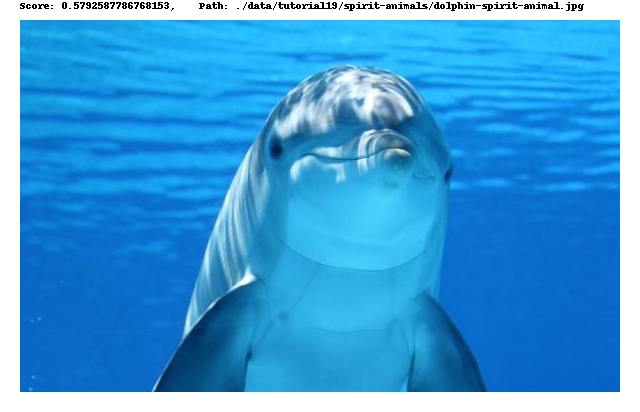

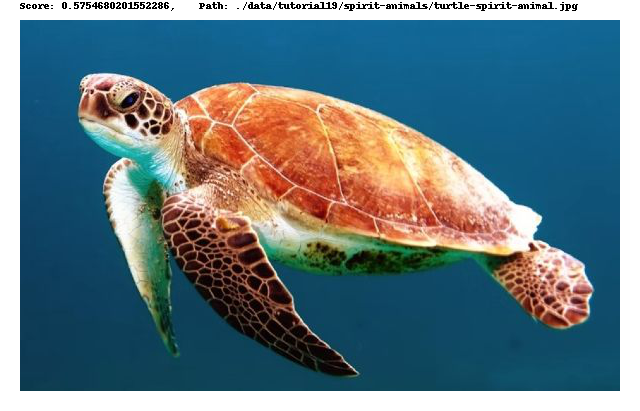

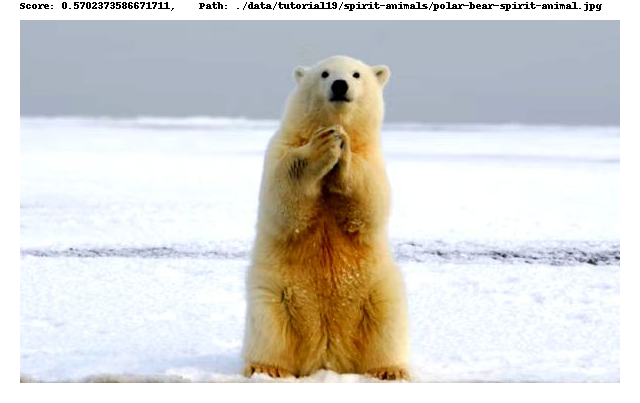

In [69]:
from io import BytesIO
import PIL
from PIL import ImageDraw
from IPython.display import display, Image

def display_img_array(ima, score):
    im = PIL.Image.open(ima)
    img_with_border = PIL.ImageOps.expand(im ,border=20, fill='white')

    # Add Text to an image
    img = ImageDraw.Draw(img_with_border)
    img.text((20, 0), f"Score: {score},    Path: {ima}", fill=(0, 0, 0))

    bio = BytesIO()
    img_with_border.save(bio, format='png')
    display(Image(bio.getvalue(), format='png'))

images_array = [doc.content for doc in results_mm]
scores = [doc.score for doc in results_mm]
for ima, score in zip(images_array, scores):
    display_img_array(ima, score)

## About us

This [Haystack](https://github.com/deepset-ai/haystack/) notebook was made with love by [deepset](https://deepset.ai/) in Berlin, Germany

We bring NLP to the industry via open source!  
Our focus: Industry specific language models & large scale QA systems.  
  
Some of our other work: 
- [German BERT](https://deepset.ai/german-bert)
- [GermanQuAD and GermanDPR](https://deepset.ai/germanquad)
- [FARM](https://github.com/deepset-ai/FARM)

Get in touch:
[Twitter](https://twitter.com/deepset_ai) | [LinkedIn](https://www.linkedin.com/company/deepset-ai/) | [Discord](https://haystack.deepset.ai/community/join) | [GitHub Discussions](https://github.com/deepset-ai/haystack/discussions) | [Website](https://deepset.ai)

By the way: [we're hiring!](https://www.deepset.ai/jobs)